## 1. Dust in the Erdős-Rényi random graph

Let $G(N,p)$ be an *Erdős-Rényi* (ER) random graph on $N$ vertices with parameter $p$,
which is defined to be a random graph on $N$ vertices
constructed so that each for each $0 \le i < j < N$, there is an undirected edge between $i$ and $j$
with probability $p$,
independently for each pair of vertices.
Recall that the *exploration process*, defined in class,
partitions the vertex set at each step $t$ into three sets:
*active*, $A_t$; *visited*, $V_t$, and *unvisited*, $U_t$.
It begins with $A_0 = \{0\}$ and $V_0 = \{\}$,
and at each step moves a random active vertex $v$ to the visited set,
while moving any unvisited vertices that are neighbors of $v$ to the active set.

1. Let $W_t$ be the number of new vertices added to the active set in step $t$.
   This is equal to the number of the $N-t$ unvisited vertices that the target vertex is connected to.
   Find $\phi_t(u) = \mathbb{E}[u^{W_t}]$, the generating function of $W_t$.
   
2. Let $D$ be the degree of a randomly chosen vertex,
   and let $q$ be the probability of nonextinction of a branching process with offspring distribution given by $D$.
   Describe an algorithm to numerically compute $q$ to within some reasonable numerical accuracy.
   (*Note that the generating function of $D$ is $\phi_0(u)$.*)

3. Let $C_N$ be the largest connected component of $G(N,p)$,
   let $X_u = 0$ if $u \in C_N$ and $X_u = 1$ otherwise,
   and let $Z_{N} = (1/N) \sum_{u=1}^N X_u = 1 - |C_N|/N$
   be the proportion of points *not* in the largest component.
   Explain why $\lim_{N \to \infty} \mathbb{E}[Z_{N}] \ge 1 - q$.

## 2. Branching and the exploration process

For this problem, you will modify the code that Peter wrote in class, and is [available on the website](https://petrelharp.github.io/applied_math/demos/configuration_process.html).
The code simulates the exploration process and the coupled branching process
for the configuration model with degree distribution Poisson($\lambda=0.8$), for a graph of size $N=200$.

Refactor the code as a function that takes arguments for $\lambda$, $N$, and `is_branching_process`
and returns a dictionary of relevant output (e.g., `{"size" : 1 + t, "generation" : generation, ...}`).
Use this to make a plot of cluster size against $\lambda$
for at least 200 values of $\lambda$ between 0 and 2 (so, each simulation will produce one point on the plot).
*(Note: do this with `is_branching_process=False`.)*
Does the result agree with your theoretical prediction?

In [85]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [86]:
plt.rcParams['figure.figsize'] = [8, 8]

In [90]:
import numpy as np

def explore(lam, N, is_bp=False):
    def new_degree():
        return 1 + np.random.poisson(lam)

    # an edge from i to j if j is in edges[i]
    edges = [[] for _ in range(N)]
    active = set([0])
    visited = set([])
    unvisited = set([k for k in range(N)])
    unvisited.remove(0)
    degrees = [new_degree() for _ in range(N)]
    outdegrees = degrees.copy()
    n_active = np.repeat(-1, 2*N)
    generation = [np.inf for _ in range(N)]
    generation[0] = 0

    num_ghosts = 0 # number of additional nodes
    num_ghosts_so_far = np.repeat(-1, 2*N)

    t = 0
    while len(active) > 0:
        x = active.pop()
        #print("step", t, "vertex", x)
        while outdegrees[x] > 0:
            outdegrees[x] -= 1
            M = np.sum(outdegrees[:N])
            if x < N:
                # real
                y = np.random.choice(N, size=1, p=outdegrees[:N]/M)[0]
            else:
                # ghost
                y = N + num_ghosts
                num_ghosts += 1
                outdegrees.append(new_degree())
                generation.append(np.inf)
            outdegrees[y] -= 1
            generation[y] = min(generation[y], 1 + generation[x])
            assert(outdegrees[y] >= 0)
            if y != x and y not in active:
                #print("new node")
                if y < N:
                    unvisited.remove(y)
                active.update([y])
            elif is_bp:
                outdegrees.append(new_degree())
                outdegrees.append(new_degree())
                active.update([N+num_ghosts, N+num_ghosts+1])
                generation.append(1 + generation[x])
                generation.append(1 + generation[x])
                num_ghosts += 2
            #print("connecting to", y)
            #edges[x].append(y)
            #edges[y].append(x)
        assert(outdegrees[x] == 0)
        visited.update([x])
        n_active[t] = len(active)
        num_ghosts_so_far[t] = num_ghosts
        t += 1
        assert(len(visited) == t)
    out = {"size" : 1 + t,
           "generation" : generation,
           "n_active" : n_active}
    return out


In [89]:
lamvals = np.linspace(0,2,200)
sizes = [explore(lam, N=1000)['size'] for lam in lamvals]

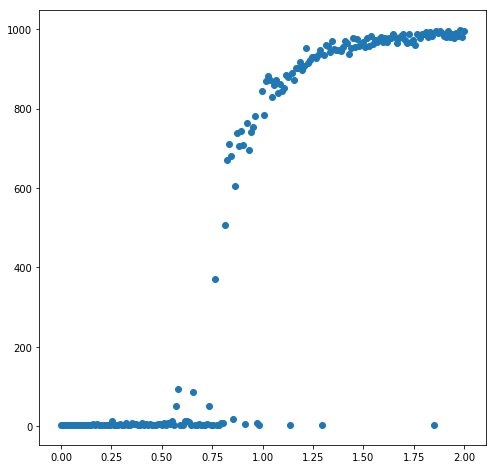

In [91]:
fig, ax = plt.subplots()
ax.scatter(lamvals, sizes)


# spanning trees on the grid

For this problem we're going to verify a curious formula: the number of spanning trees on the $m \times n$ grid graph is
$$
\frac{1}{mn} \prod_{i,j}\left (4 - 2 \cos \frac{i\pi}{m} - 2 \cos \frac{j \pi}{n} \right )
$$

where the product is taken over all pairs $(i,j)$ with $(i,j) \neq (0,0), 0 \leq i < m, 0 \leq j < n$.

(a) It is not obvious that the above quantity is an integer (or even a rational number).  Evaluate the formula for small $m,n$, and look up the corresponding numbers on the OEIS.

(b) Let $\chi_n(x)$ be the characteristic polynomial of the Laplacian $\Delta_n$ of the $n$-path.  Write $\chi_n$ in terms of the [Chebyshev polynomials of the second kind](https://en.wikipedia.org/wiki/Chebyshev_polynomials).  

I knew to do this by computing $\chi_5 = x^5 - 8x^4 + 21x^3 - 20x^2 + 5x$, and then looking up those coefficients on the OEIS, which then told me to look up Chebyshev polynomials on Wikipedia.  You may take anything Wikipedia says about Chebyshev polynomials as true.

(c) Continue to use Wikipedia to learn what the roots of $\chi_n(x)$ are. Then use the matrix tree theorem to verify the formula above.  This goes much like the problem, on a previous assignment, where you computed the eigenvalues of the adjacency matrix of the hypercube.

